<a href="https://colab.research.google.com/github/manar1992/saffron-dashboard/blob/main/Logistic%20Regression%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📌 SECTION 1: رفع الملف المضغوط إلى Google Colab
from google.colab import files
uploaded = files.upload()

Saving THZ_dataset_det_VOC.zip to THZ_dataset_det_VOC.zip


In [ ]:
# 📌 SECTION 2: فك ضغط الملف
import zipfile
import os

zip_path = "THZ_dataset_det_VOC.zip"
extract_path = "/content/THZ_dataset_det_VOC"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction completed.")

✅ Extraction completed.


In [ ]:
# 📌 SECTION 3: تحميل الصور وتصنيفها (1: weapon, 0: non-weapon)
import cv2
import numpy as np
import pandas as pd

# مسار الصور
img_dir = "/content/THZ_dataset_det_VOC/JPEGImages"

# الأسلحة المحتملة في اسم الصورة
weapon_keywords = ['GA', 'KK', 'SS', 'MD', 'CK']

X = []
y = []

for filename in os.listdir(img_dir):
    if filename.endswith(".jpg"):
        path = os.path.join(img_dir, filename)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            X.append(img)

            # التصنيف بناءً على اسم الملف
            label = 1 if any(weapon in filename for weapon in weapon_keywords) else 0
            y.append(label)

X = np.array(X)
y = np.array(y)

print("✅ عدد الصور:", len(X))
print("✅ شكل الصورة:", X[0].shape)
print("✅ توزيع التصنيفات:\n", pd.Series(y).value_counts())

✅ عدد الصور: 3157
✅ شكل الصورة: (224, 224, 3)
✅ توزيع التصنيفات:
 1    1842
0    1315
Name: count, dtype: int64


In [ ]:
# 📌 SECTION 4: تقسيم البيانات إلى تدريب واختبار
from sklearn.model_selection import train_test_split

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# تحويل الصور إلى float
X_train = X_train / 255.0
X_test = X_test / 255.0

print("✅ حجم بيانات التدريب:", X_train.shape)
print("✅ حجم بيانات الاختبار:", X_test.shape)

✅ حجم بيانات التدريب: (2525, 224, 224, 3)
✅ حجم بيانات الاختبار: (632, 224, 224, 3)


In [ ]:
# 📌 SECTION 5: بناء نموذج CNN بسيط
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # لأنه تصنيف ثنائي
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,457 (45.64 MB)

 Trainable params: 11,963,457 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 📌 SECTION 6: تدريب النموذج
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32
)

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.5644 - loss: 0.7607 - val_accuracy: 0.5839 - val_loss: 0.6783
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.6037 - loss: 0.6570 - val_accuracy: 0.6408 - val_loss: 0.6454
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.7000 - loss: 0.5734 - val_accuracy: 0.6851 - val_loss: 0.5920
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.7978 - loss: 0.4382 - val_accuracy: 0.7231 - val_loss: 0.5253
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.8607 - loss: 0.3170 - val_accuracy: 0.7753 - val_loss: 0.4783


In [ ]:
# 📌 SECTION 7: تقييم النموذج
#loss, acc = model.evaluate(X_test, y_test)
#print(f"✅ Test Accuracy: {acc:.2%}")
# احسب دقة التدريب
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)

# احسب دقة الاختبار
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# اطبعي النتيجتين للمقارنة
print(f"✅ Train Accuracy: {train_acc:.2%}")
print(f"✅ Test Accuracy : {test_acc:.2%}")


✅ Train Accuracy: 94.26%
✅ Test Accuracy : 77.53%


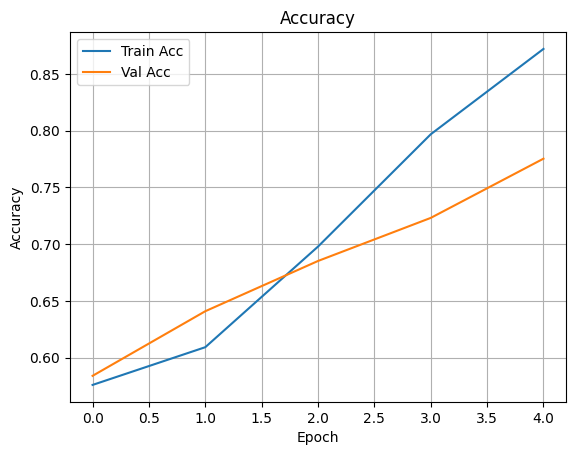

In [ ]:
# 📌 SECTION 8: رسم منحنى التدريب
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()